In [72]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

读入数据

In [73]:
# 指定文件路径
file_path = "data/final_dataset.txt"

# 读取文本文件到DataFrame
data = pd.read_table(file_path)

# 显示DataFrame
print(data)

                                                     Text  Target_Label
0                                   Bugis oso near wat...             0
1       Go until jurong point, crazy.. Available only ...             0
2          I dunno until when... Lets go learn pilates...             0
3       Den only weekdays got special price... Haiz......             0
4                                  Meet after lunch la...             0
...                                                   ...           ...
115959                           I am jumping JUMPING!!!!             1
115960                      What does all this amount to?             1
115961                        A man went fishing one day.             1
115962                    I’d do it again in a heartbeat!             1
115963       I’m not fond of wearing closed shoes either.             1

[115964 rows x 2 columns]


In [74]:
data.columns = ['text','label']
data.head()

,text,label
0,Bugis oso near wat...,0
1,"Go until jurong point, crazy.. Available only ...",0
2,I dunno until when... Lets go learn pilates...,0
3,Den only weekdays got special price... Haiz......,0
4,Meet after lunch la...,0


# 探索式数据分析

清理空缺值

In [75]:
data.isna().sum()

text     11
label     0
dtype: int64

In [76]:
data = data.dropna()

In [77]:
data

,text,label
0,Bugis oso near wat...,0
1,"Go until jurong point, crazy.. Available only ...",0
2,I dunno until when... Lets go learn pilates...,0
3,Den only weekdays got special price... Haiz......,0
4,Meet after lunch la...,0
...,...,...
115959,I am jumping JUMPING!!!!,1
115960,What does all this amount to?,1
115961,A man went fishing one day.,1
115962,I’d do it again in a heartbeat!,1


<AxesSubplot:>

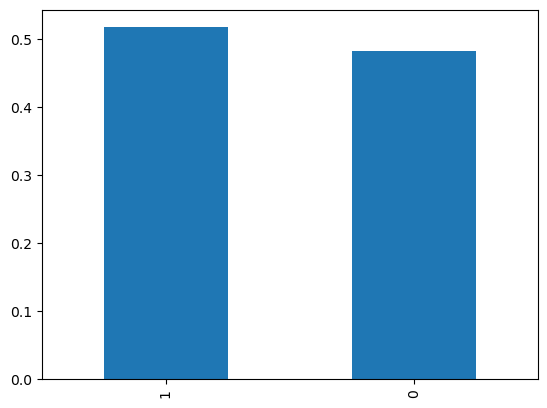

In [78]:
# check target balance
data['label'].value_counts(normalize = True).plot.bar()

# 文本预处理


In [79]:
# text preprocessing
# download nltk 
import nltk
# nltk.download('all') # 只需跑一次


In [81]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def clean_tokenise_text(text):
    lemmatizer = WordNetLemmatizer()
    r = re.sub('[^a-zA-Z]', ' ', text)
    r = r.lower()
    r = r.split()
    # r = [word for word in r if word not in stopwords.words('english')]
    r = [lemmatizer.lemmatize(word) for word in r]
    r = ' '.join(r)
    return r

# 训练-测试-拆分

In [82]:
# Create Feature and Label sets
X = data['text']
y = data['label']
# train test split (66% train - 33% test)
from sklearn.model_selection import train_test_split
X_train_uncleaned, X_test_uncleaned, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

print('Training Data :', X_train_uncleaned.shape)
print('Testing Data : ', X_test_uncleaned.shape)

Training Data : (77688,)
Testing Data :  (38265,)


### 提取 test.txt - 为 large language model 的 input

In [83]:
df_test = pd.DataFrame({'Text': X_test_uncleaned, 'Target_Label': y_test})
df_test.to_csv('./data/test.txt', sep='\t', index=False)

In [95]:
print(type(X_test_uncleaned))
print(X_test_uncleaned.head())

<class 'pandas.core.series.Series'>
84851          If he wants a place, he must jostle for it.
11852    Boring. Bored. Waiting for david. I know he's ...
34641                                          Haha 6pm lo
87403    I told her last week that I was ready for her ...
27616                                         Yep! Cya :-)
Name: text, dtype: object


In [86]:
# processed X train and X test - tokenisation
X_train = X_train_uncleaned.apply(clean_tokenise_text)
X_test = X_test_uncleaned.apply(clean_tokenise_text)

# print(X_test_processed[:5])
# print(type(X_test_processed))

print('Training Data :', X_train.shape)
print('Testing Data : ', X_test.shape)

Training Data : (77688,)
Testing Data :  (38265,)


In [94]:
print(type(X_test))
print(X_test.head())

<class 'pandas.core.series.Series'>
84851             if he want a place he must jostle for it
11852    boring bored waiting for david i know he s gon...
34641                                           haha pm lo
87403    i told her last week that i wa ready for her t...
27616                                              yep cya
Name: text, dtype: object


# 特征提取


In [88]:
# Train Bag of Words model

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

X_train_cv = cv.fit_transform(X_train)

X_train_cv.shape

(77688, 41208)

# 模型训练与评估

In [90]:
from sklearn.linear_model import LogisticRegression

# 创建逻辑回归模型，增加 max_iter 参数
lr = LogisticRegression(max_iter=15000)  # 适当增加max_iter的值

# 在训练集上拟合模型
lr.fit(X_train_cv, y_train)

# transform X_test using CV
X_test_cv = cv.transform(X_test)

# 生成预测
predictions = lr.predict(X_test_cv)

# 显示预测结果
predictions

array([1, 0, 0, ..., 1, 1, 0])

In [91]:
# confusion matrix

import pandas as pd

from sklearn import metrics

df = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), index=['1','0'], columns=['1','0'])

df

,1,0
1,17018,1563
0,1413,18271


In [92]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 创建SVM模型
svm_model = SVC(kernel='linear')  # 使用线性核函数，也可以尝试其他核函数如'rbf'等

# 在训练集上拟合模型
svm_model.fit(X_train_cv, y_train)

# transform X_test using CV
X_test_cv_svm = cv.transform(X_test)

# 生成SVM模型的预测
svm_predictions = svm_model.predict(X_test_cv_svm)

# 计算SVM模型的准确度
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy}")


SVM Accuracy: 0.9189076179276101


In [93]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# 创建Multinomial Naive Bayes模型
nb_model = MultinomialNB()

# 在训练集上拟合模型
nb_model.fit(X_train_cv, y_train)

# transform X_test using CV
X_test_cv_nb = cv.transform(X_test)

# 生成朴素贝叶斯模型的预测
nb_predictions = nb_model.predict(X_test_cv_nb)

# 计算朴素贝叶斯模型的准确度
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy}")


Naive Bayes Accuracy: 0.9104403501894682
